In [1]:
from _common.database_communicator.db_connector import DBConnector
import pandas as pd
from ml_model.src.data.data_preprocessing import DataPreprocessor
from ml_model.src.models.train_model import XGBoostRegressor
from _common.misc.variables import (
    CATEGORICAL_FEATS,
    NUMERIC_FEATS,
    TARGET_COL,
    FEAT_COLS,
    LOCATION_LIST,
)
from crawler.data_cleaner.data_transformer import DataTransformer

In [38]:
preprocessor = DataPreprocessor()
preprocessor.run_preprocessing_pipeline(cast_types=False)
df = preprocessor.get()

In [39]:
df["floor"] = df["floor"].astype("float")
df = df[df["floor"] < 30.0]
df["year_built"] = df["year_built"].astype("float")

/tmp/ipykernel_27443/1022978667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year_built"] = df["year_built"].astype("float")


In [40]:
df = df[df["size"] < 1000.0]

In [41]:
df["status"] = df["status"].astype("category")
df["location"] = df["location"].astype("category")
df["property_condition"] = df["property_condition"].astype("category")
df["property_type"] = df["property_type"].astype("category")

In [42]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

df[["size", "rooms", "floor", "year_built"]] = scale.fit_transform(
    df[["size", "rooms", "floor", "year_built"]]
)

In [43]:
df.head()

,status,size,property_type,rooms,floor,year_built,property_condition,location,price
52,wtórny,-0.527649,blok,0.258898,-0.627334,0.412364,do zamieszkania,Grunwald,569000.0
56,pierwotny,-0.047506,blok,0.258898,0.228095,0.583038,do wykończenia,Podolany,655500.0
60,wtórny,0.555167,blok,1.192202,-0.199619,0.412364,do zamieszkania,Jeżyce,1249000.0
62,pierwotny,-1.050179,kamienica,-1.607709,-0.199619,0.583038,do wykończenia,Stare Miasto,540200.0
63,wtórny,-0.691496,blok,-0.674406,1.083524,0.554592,do wykończenia,Łacina,559000.0


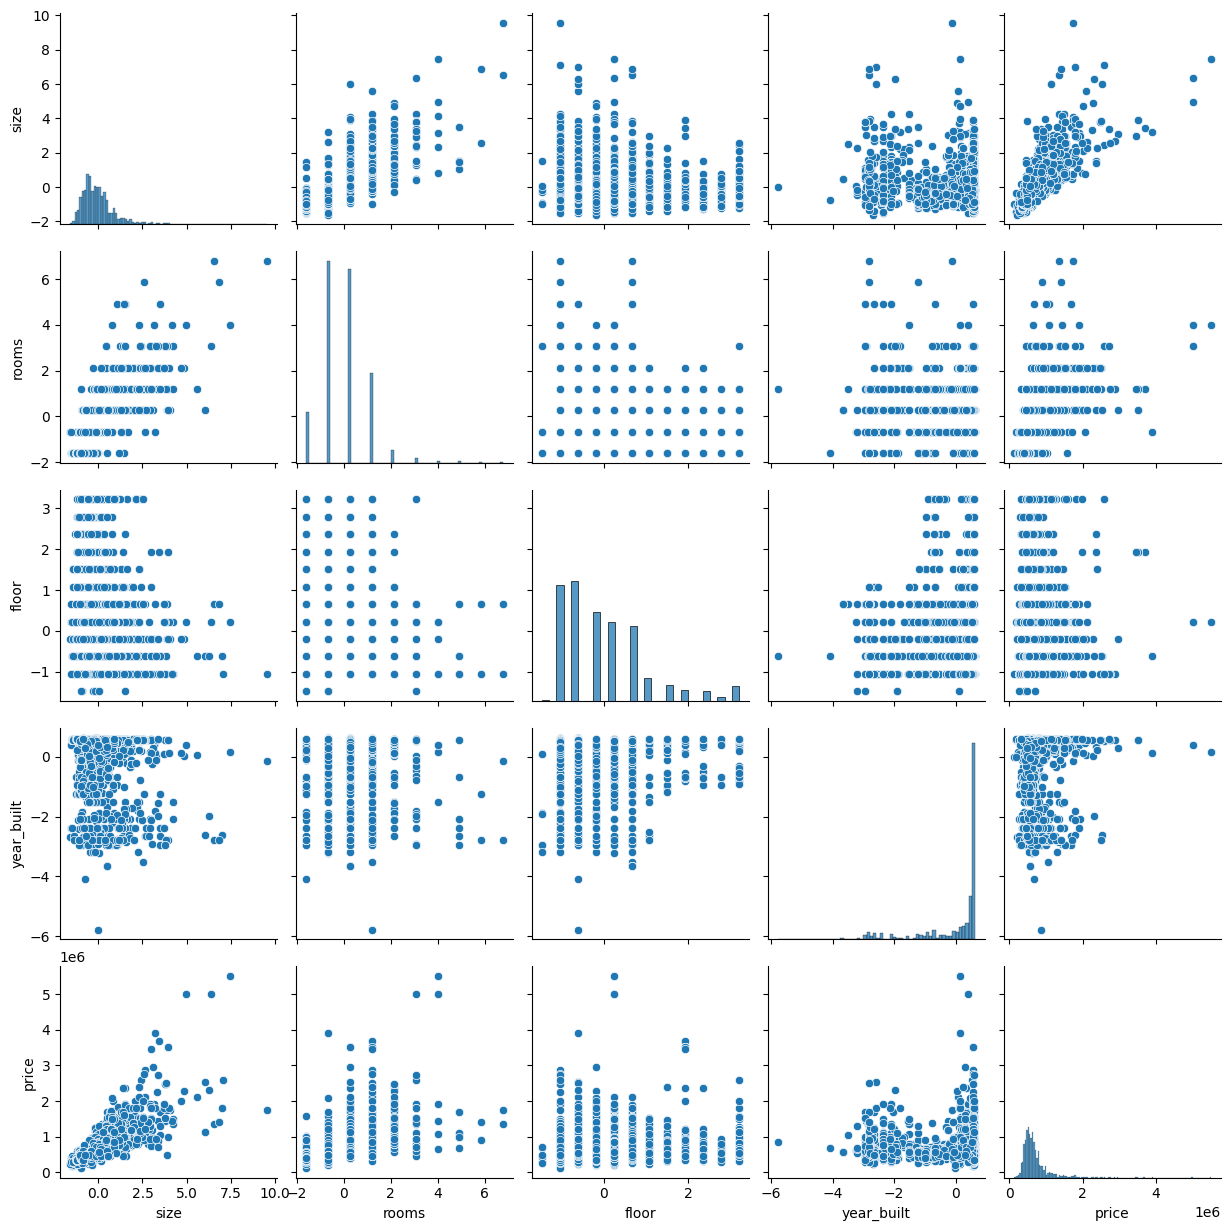

In [44]:
import seaborn as sns

sns.pairplot(df)

In [45]:
cor = df[NUMERIC_FEATS + [TARGET_COL]].corr()
cor.style.background_gradient(cmap="coolwarm", axis=None)

,size,rooms,price
size,1.000000,0.773170,0.784244
rooms,0.773170,1.000000,0.517653
price,0.784244,0.517653,1.000000


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[FEAT_COLS], df[TARGET_COL], test_size=0.2, random_state=42
)

In [47]:
X_train.head()

,status,size,property_type,rooms,floor,year_built,property_condition,location
888,pierwotny,-0.317141,blok,0.258898,1.511238,NaN,do wykończenia,Rataje
3370,pierwotny,-0.056054,blok,1.192202,1.083524,0.583038,do wykończenia,Starołęka Mała
3526,pierwotny,0.488916,apartamentowiec,1.192202,0.655809,0.583038,NaN,Naramowice
617,pierwotny,-1.134239,NaN,-1.607709,-1.055048,NaN,NaN,Łacina
624,pierwotny,-1.198354,blok,-1.607709,1.938953,0.583038,do wykończenia,Rataje


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END colsample_bytree=1.0, eta=0.2, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=200, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=5, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=1.0, eta=0.2, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=200, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=5, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=1.0, eta=0.2, gamma=0.2, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=200, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=5, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.9, eta=0.3, gamma=0, learning_rate=0.3, max_depth=25, min_child_weight=10, n_estimators=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.9, eta=0.3, gamma=0, learning_rate=0.3, max_depth=25, min_child_weight=10, n_estimators=

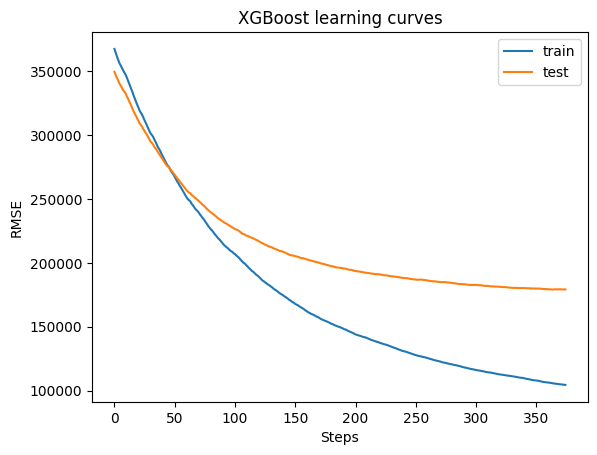

MAE: 82646.73808255518
RMSE: 179085.18226963314
R2: 0.7410525710728691


In [48]:
xgb_regressor = XGBoostRegressor()
xgb_regressor.random_search_cv(X_train, y_train, n_iter=500, random_state=30, verbose=2)
xgb_regressor.train(X_train, y_train, X_test, y_test, verbose=False)
xgb_regressor.plot_learning_curves()
xgb_regressor.evaluate(X_test, y_test)

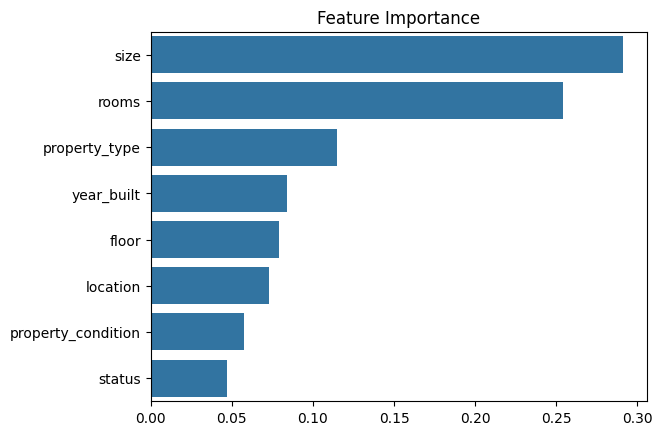

In [49]:
import matplotlib.pyplot as plt

feature_importance = xgb_regressor.feature_importances_
sns.barplot(
    x=feature_importance,
    y=FEAT_COLS,
    order=[FEAT_COLS[i] for i in reversed(feature_importance.argsort())],
)
plt.title("Feature Importance")
plt.show()

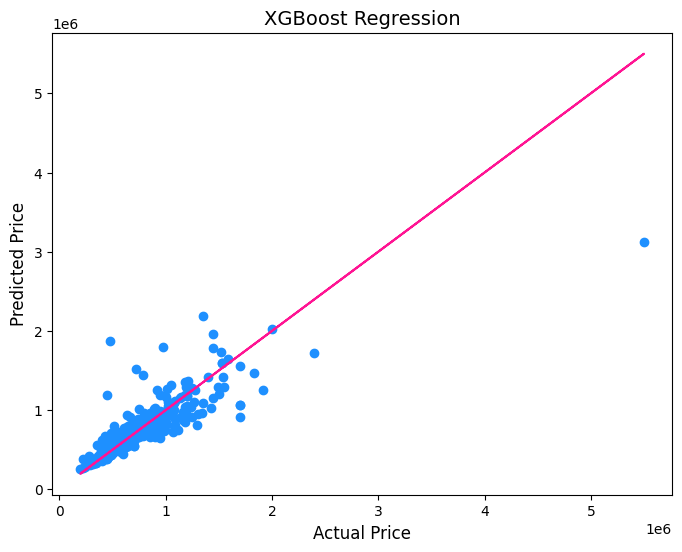

In [50]:
prediction_xgbr = xgb_regressor.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(x=y_test, y=prediction_xgbr, color="dodgerblue")
plt.plot(y_test, y_test, color="deeppink")
plt.xlabel("Actual Price", fontsize=12)
plt.ylabel("Predicted Price", fontsize=12)
plt.title("XGBoost Regression", fontsize=14)
plt.show()

# TFDF


In [36]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

2023-12-10 23:10:52.586122: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 23:10:52.811485: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 23:10:52.811718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 23:10:52.842459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 23:10:52.932984: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 23:10:52.936689: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [37]:
train_ds_pd = pd.concat([X_train, y_train], axis=1)
test_ds_pd = pd.concat([X_test, y_test], axis=1)

label = "price"

# Convert dataframe to TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION
)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [44]:
rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mae"])

Use /tmp/tmpdyh9i6br as temporary training directory


In [45]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.366074. Found 3180 examples.
Training model...


[INFO 23-12-10 22:35:19.1642 CET kernel.cc:1233] Loading model from path /tmp/tmpdyh9i6br/model/ with prefix 3251ecc2ca20490f


Model trained in 0:00:01.540847
Compiling model...


[INFO 23-12-10 22:35:19.6465 CET decision_forest.cc:660] Model loaded with 300 root(s), 274724 node(s), and 8 input feature(s).
[INFO 23-12-10 22:35:19.6466 CET abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 23-12-10 22:35:19.6466 CET kernel.cc:1061] Use fast generic engine


Model compiled.


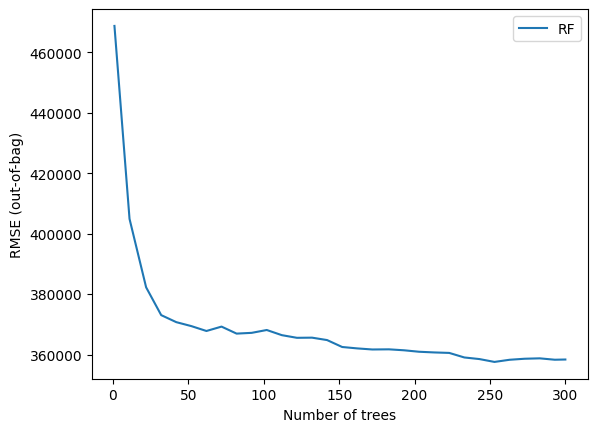

In [46]:
import matplotlib.pyplot as plt

logs_rf = rf.make_inspector().training_logs()
plt.plot(
    [log.num_trees for log in logs_rf],
    [log.evaluation.rmse for log in logs_rf],
    label="RF",
)
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.legend()
plt.show()

In [47]:
evaluation = rf.evaluate(x=test_ds, return_dict=True)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 278ms/step - loss: 0.0000e+00 - mae: 155737.1719
loss: 0.0000
mae: 155737.1719


In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

preds = rf.predict(test_ds)

# Evaluate the model
mae_score = mean_absolute_error(y_test, preds)
print("MAE:", mae_score)

rmse_score = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse_score)

r2 = r2_score(y_test, preds)
print("R2:", r2)

1/1 [==============================] - 0s 122ms/step
MAE: 155737.1748241206
RMSE: 430822.28567335434
R2: 0.7391682819093057


1/1 [==============================] - 0s 72ms/step


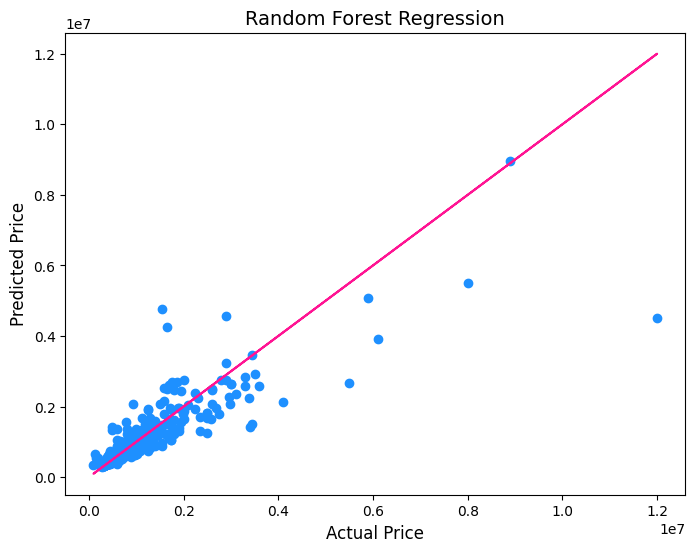

In [29]:
prediction_rf = rf.predict(test_ds)
plt.figure(figsize=(8, 6))
plt.scatter(x=y_test, y=prediction_rf, color="dodgerblue")
plt.plot(y_test, y_test, color="deeppink")
plt.xlabel("Actual Price", fontsize=12)
plt.ylabel("Predicted Price", fontsize=12)
plt.title("Random Forest Regression", fontsize=14)
plt.show()